# Optical Modualtors - Mach-Zehnder Configuration with a Lateral PN Junction

<p style="font-size:18px">
This notebook demonstrates peformance metrics for a Mach-Zehnder-type optical modulator with a lateral pn nunction.
<p style="font-size:18px">  
*** Launch the notebook by selecting "Run All" under the "Cell" menu. View code by clicking on the "Show Code" button just below.
***

In [1]:
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Button, Dropdown, IntProgress, HBox, VBox
from IPython.display import display
import numpy
from numpy import fft
from scipy import special, signal
from bokeh.io import push_notebook, curdoc
from bokeh.themes import Theme
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Range1d, LinearAxis, Title, Label, Span, Band, Slider
from bokeh.layouts import widgetbox
from bokeh.models.widgets import RadioButtonGroup, Select
from bokeh.layouts import column, row
from scipy.interpolate import spline
import yaml

output_notebook()

curdoc().theme = Theme(json=yaml.load("""
    attrs:
        Figure:
            background_fill_color: "lightgray"
            outline_line_color: black
            height: 400
            width: 400
        Grid:
            grid_line_color: white
            grid_line_alpha: 0.5
        Axis:
            axis_label_text_font_size: "12pt"
            axis_label_text_font_style: "normal"
            major_label_text_font_size: "12pt"
            major_label_text_font_style: "normal"
        Line:
            line_alpha: 1
            line_width: 1.5
        Title:
            text_font_style: "normal"
            text_font_size: "12pt"
    """,Loader=yaml.FullLoader))
#  Loader=yaml.FullLoader
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
.''')

Loading BokehJS ...

## Principle of Operation

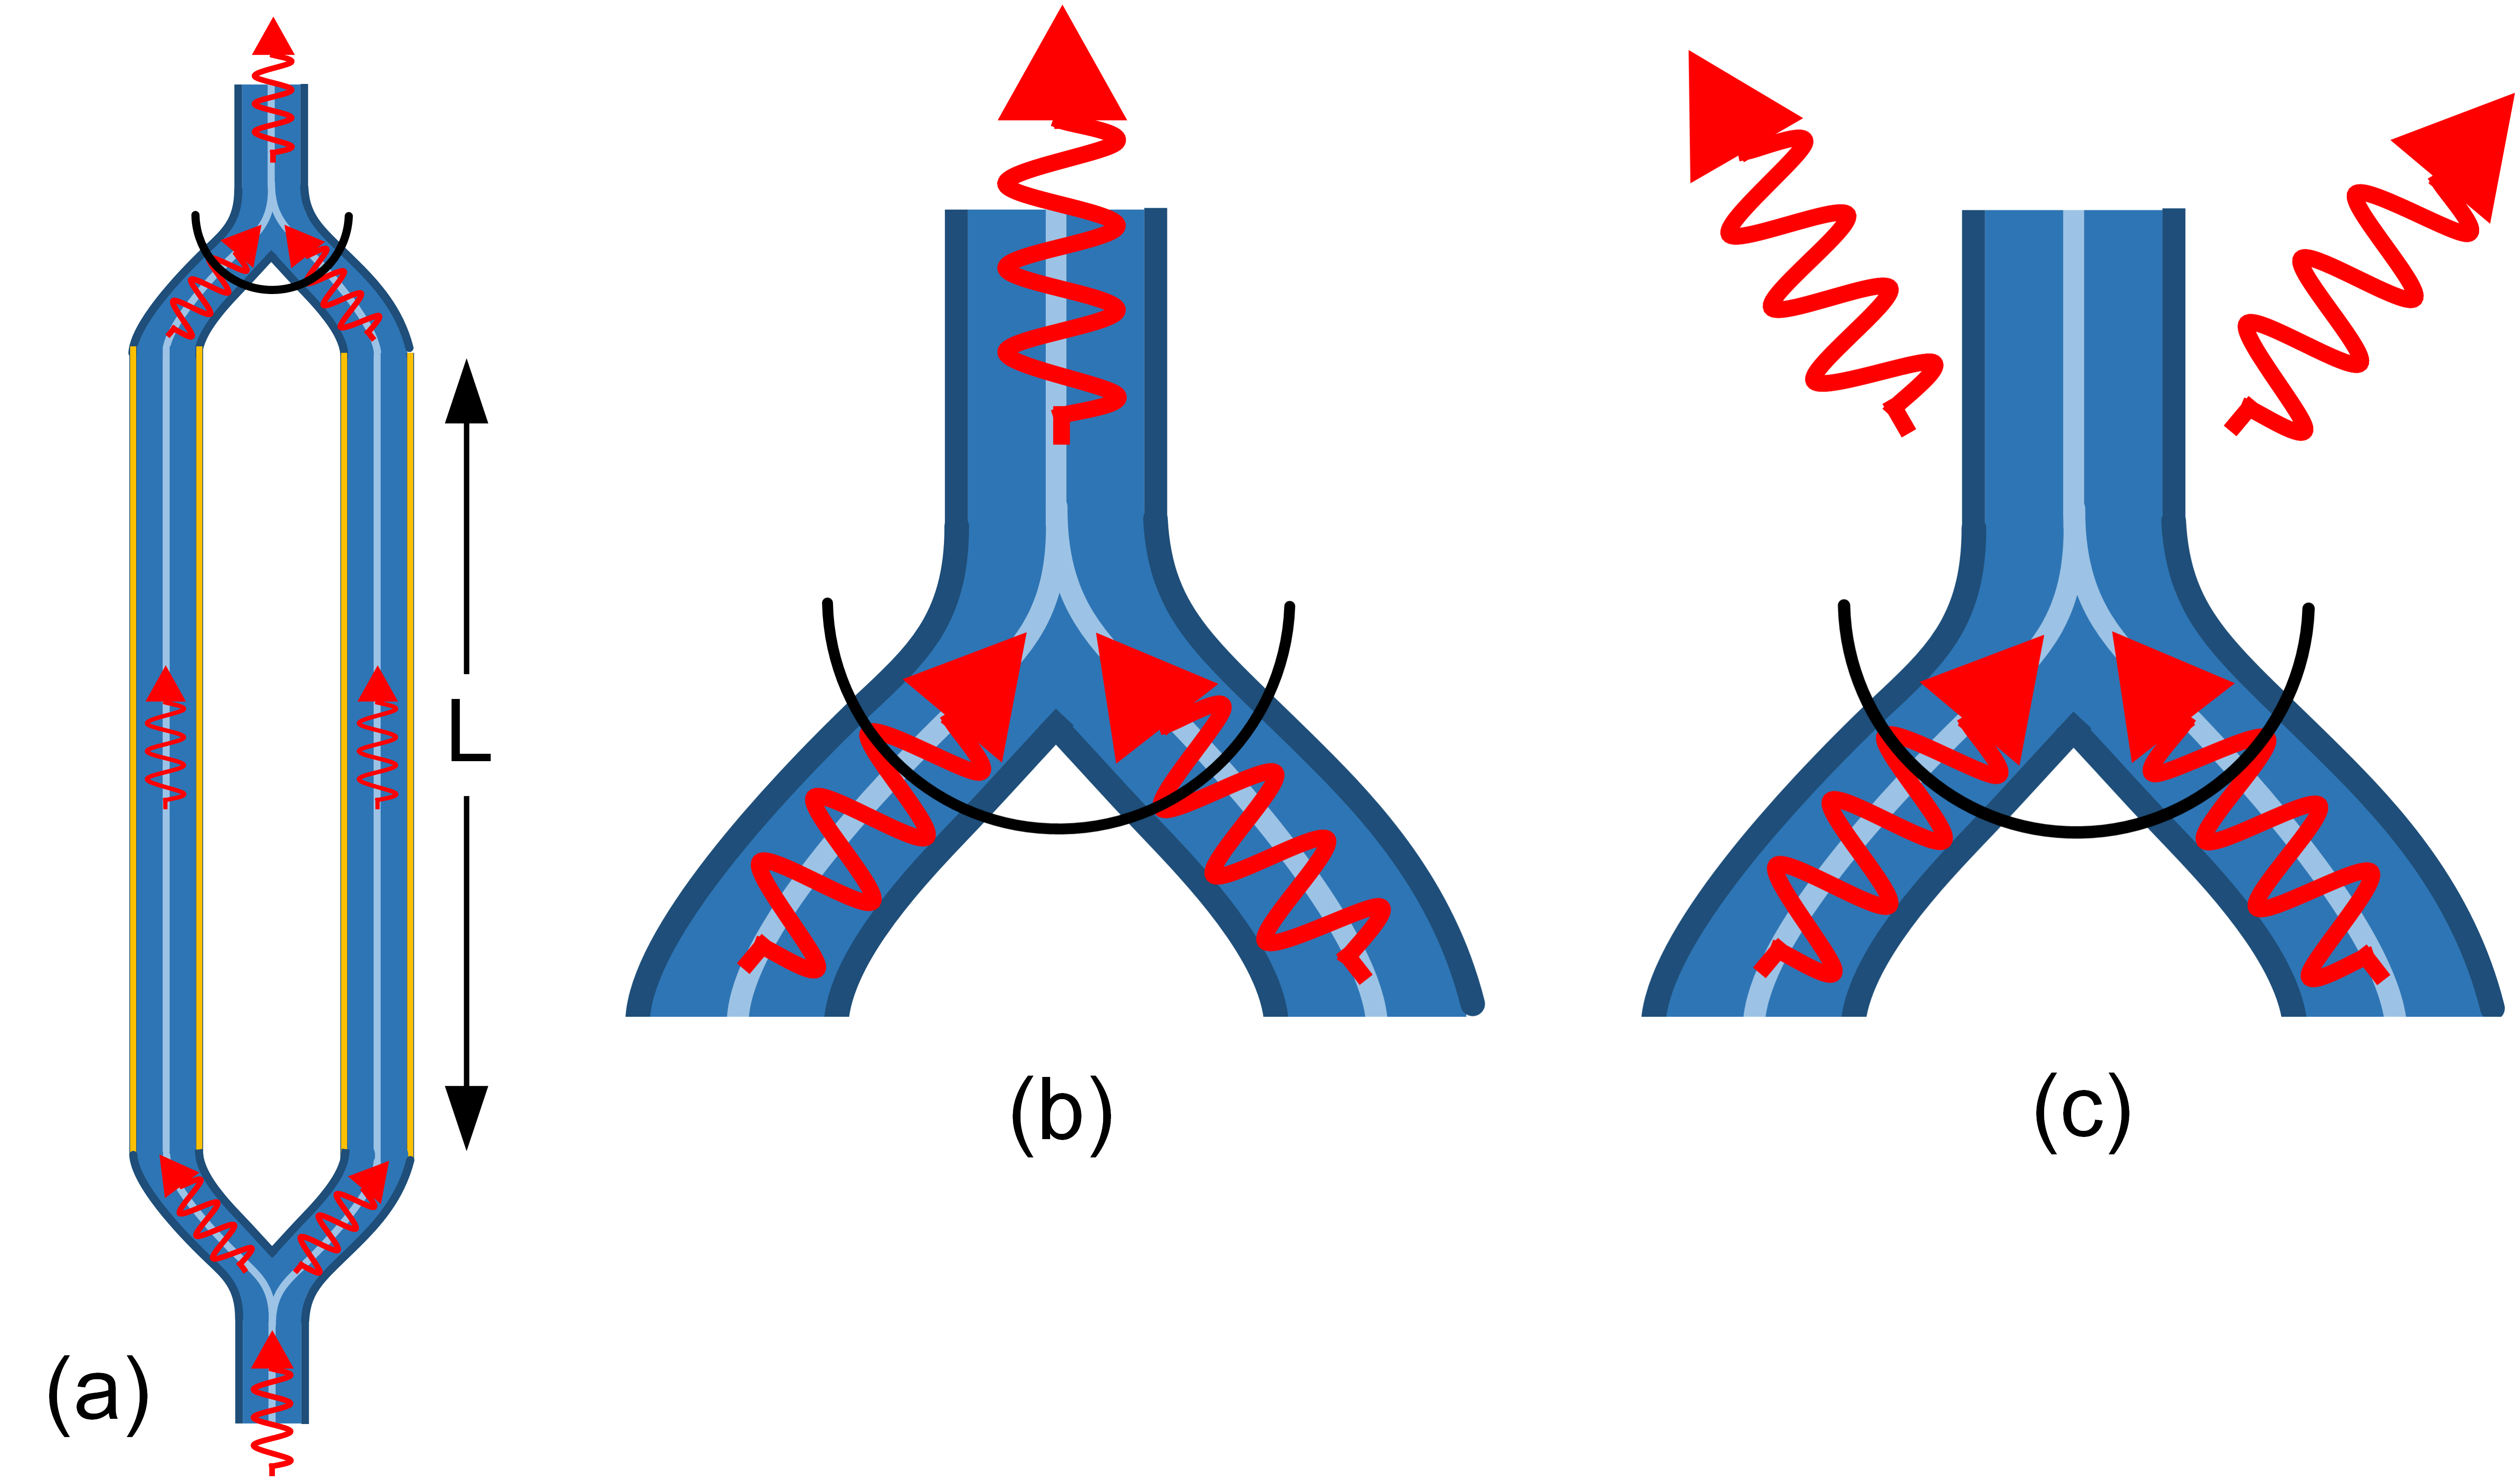

In [2]:
from IPython.core.display import Image
Image(url='https://i.imgur.com/wOqqmJl.png',embed=True,width=600)

<p style="font-size:18px">
Figure 1.
<p style="font-size:18px">
The basic principle of a Mach-Zehnder optical modulator is that a phase modulaion is used to implement an amplitude modulation. An optical beam is introduced into two arms of the interferometer, as illustrated above. After each beam propagates a geometric distance of length L, the beams are recombined. The beams interfere constructively to give a large output if they are in phase in the output waveguide. The beams radiate away from the waveguide, resulting in a small output if the beams are out of phase in the output waveguide. Charge is injected into one or both of the arms in order to induce a change in the effective index of the waveguide modes and to adjust the relative phase of the beams at the end of the arms.
    
<p style="font-size:18px">
In a typical configuration, the amount of free charge in an interferometer arm is controlled by creating a lateral pn junction with the interface between the p and the n layers located in a rib waveguide, as pictured above. Varying the voltage between the metal contacts varies the depletion width.

## Numerical Method for Calculating Optical Mode Profiles and Effective Indices

<p style="font-size:18px">
This notebook uses a finite difference mode solver to profiles and effecive index for the two lowest order modes, TE$_1$ and TM$_1$ for an optical rib waveguide. The finite difference method is used to discretize and solve a Helmholtz equation for the y-x profiles for the two lowest order optical modes (those that have the largest effective indices and corresponding propagation constants). The routine gives magnetic field H values that are larger, relative to the electric field values E, than actual values by the constnat $\sqrt {{\mu _0}/{\varepsilon _0}}$. The linear relationship between H and E means that we can find quantities of interest for an optical modulator (e.g. effective index, contributions to the effective index and modal aborption from free charge) using only the field H.

<p style="font-size:18px">
To solve for waveguide modes we need to solve the Helmholtz equation
$$\frac{{{\partial ^2}}}{{\partial {x^2}}}{H_y}(x,y) + \frac{{{\partial ^2}}}{{\partial {y^2}}}{H_y}(x,y + \left( {{n^2}{k^2} - {\beta ^2}} \right){H_y}(x,y) = 0 ,$$
an eigenvalue equation that can be rewritten as
$$\underbrace {\left[ {\frac{{{\partial ^2}}}{{\partial {x^2}}} + \frac{{{\partial ^2}}}{{\partial {y^2}}} + \left( {{n^2}{k^2} - {\beta ^2}} \right)} \right]}_{{\rm{Operator}}}{H_y}(x,y) = \underbrace {{\beta ^2}}_{{\rm{Constant}}} \times \;{H_y}(x,y).$$
This equation is solved numerically by converting it to a matrix equation
$$\left[ {\begin{array}{*{20}{c}}
{{O_{11}}}&{{O_{12}}}&{...}&{{O_{1q}}}\\
{{O_{21}}}&{{O_{22}}}&{}&{}\\
{...}&{}&{...}&{}\\
{{O_{p1}}}&{}&{}&{{O_{pq}}}
\end{array}} \right]\left[ {\begin{array}{*{20}{c}}
{H_{11}^y}\\
{H_{21}^y}\\
{}\\
{H_{pq}^y}
\end{array}} \right] = {\beta ^2}\left[ {\begin{array}{*{20}{c}}
{H_{11}^y}\\
{H_{21}^y}\\
{}\\
{H_{pq}^y}
\end{array}} \right]$$  
where the matrix O is the discretized operator and $H^y _{pq}$ are the values of H$_y$ on a spatial grid, as ilustrated below.

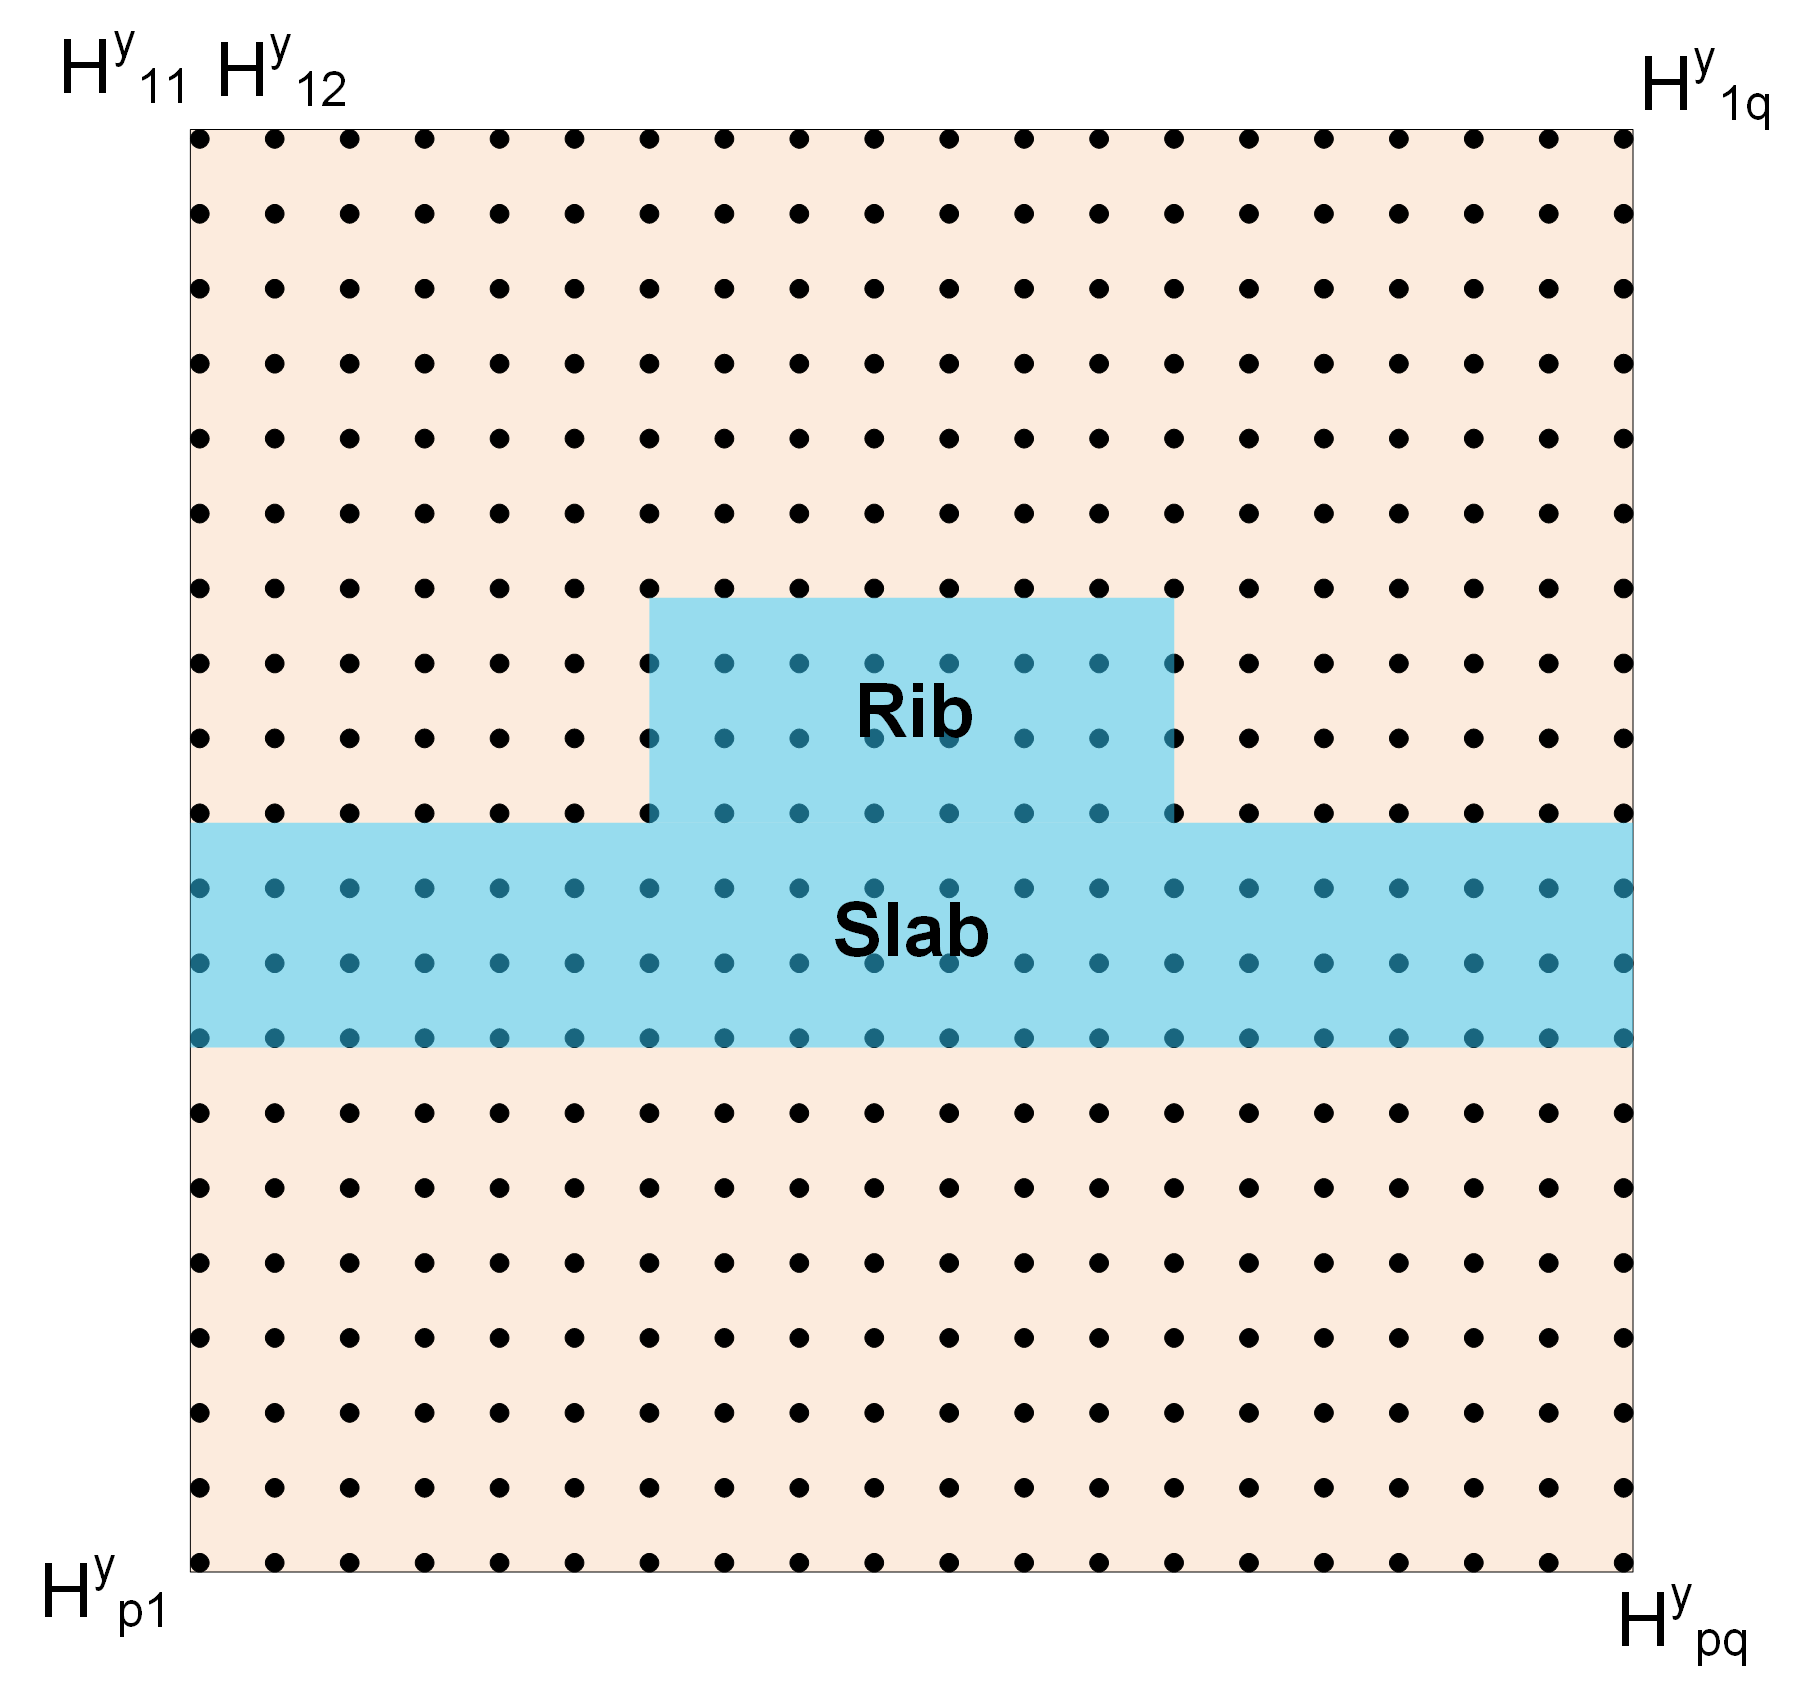

In [3]:
from IPython.core.display import Image
Image(url='https://i.imgur.com/aMrcyom.png',embed=True,width=400)

<p style="font-size:18px">
The process by which the operator is discretized includes replacing derivatives with finite differences. For example, the derivate
$$\frac{{\partial {H_y}\left( {x,y} \right)}}{{\partial x}}$$
is assigned values on the grid given by
$$H_{ij}^y{{\kern 1pt} ^\prime } = \frac{{H_{i + 1,j}^y - H_{i - 1,j}^y}}{{2\Delta x}}$$
There are mulitple algorithms and many routines available to compute the eigenvalues ($\beta$) and the eigenvectors ($H_{11}^y,\;H_{21}^y,\;\;...\;H_{ij}^y...\;H_{pq}^y$) for this kind of matrix equation. The finite difference mode solver used in this notebook can be accessed at http://lbolla.github.io/EMpy/.

<p style="font-size:18px">
We define a function that gives the refractive index that specifies the waveguide. The function is used to
assign values of refractive index on the computational grid. To define the function we need to provide values for the height
and width of the rib, and for the height and width of the slab. These values should be given assuming the units are meters.

<p style="font-size:18px">
Next we specify the grid points and read in mode profiles on the grid that were simulated previously. Corresponding effective indices and confinement factors are also read in.

In [4]:
# Compute the grid
xm = numpy.linspace(-1.0e-6, 1.0e-6, 125)
ym = numpy.linspace(-1.0e-6, 1.0e-6, 125)
xms = numpy.linspace(-1.0e-6, 1.0e-6, 124)
yms = numpy.linspace(-1.0e-6, 1.0e-6, 124)
IA = numpy.zeros((124,124,12,5,2))
neff = numpy.zeros((12,5,2))
IA=numpy.load('IA.npy')
neff=numpy.load('neff.npy')
CF=numpy.load('CF.npy')

<p style="font-size:18px">
Next we create a more dense grid that will be used for calculation of loss and refractive index change and interpolate the mode fields calculated earlier to this larger grid.

In [5]:
from scipy import interpolate
xa = numpy.linspace(-100e-8,-20e-8,81)
xb = numpy.linspace(-199e-9,199e-9,399)
xc = numpy.linspace(20e-8,100e-8,81)
xml = numpy.concatenate([xa,xb,xc])
ya = numpy.linspace(-100e-8,-20e-8,81)
yb = numpy.linspace(-199e-9,199e-9,399)
yc = numpy.linspace(20e-8,100e-8,81)
yml = numpy.concatenate([ya,yb,yc])

xxml, yyml = numpy.meshgrid(xml, yml)
DXY=numpy.where((numpy.absolute(xxml.T)<=20e-8)*(numpy.absolute(yyml.T)<=20e-8),1,10)

IAtemp=numpy.zeros((124,124))
IAlarge = numpy.zeros((561,561,12,5,2))


for i in range(12):
    for j in range(5):
        for k in range(2):
            IAtemp=IA[:,:,i,j,k]
            f=interpolate.interp2d(xms,yms,IAtemp)
            IAlarge[:,:,i,j,k] = f(xml,yml)*DXY

<p style="font-size:18px">
Now we define functions that calculate several important quantites for a waveguide with a lateral pn junction as a funcion of doping profiles, waveguide geometry, and applied voltage. Specifically, we define functions for:
<p style="font-size:18px">
1. Charge distributions
<p style="font-size:18px">
2. Boundaries for the depletion region
<p style="font-size:18px">
3. Modal loss
<p style="font-size:18px">
4. Change in the modal effective index

In [6]:
x_height_rib = 220e-9
y_width_slab = 2000e-9
def n_high_doping(x_, y_,ribwidth,trench_depth, spacerd,conc):
        x_height_slab = x_height_rib-trench_depth
        xx, yy = numpy.meshgrid(x_, y_)
        return numpy.where((numpy.abs(xx.T-x_height_slab/2) <= x_height_slab/2) * (yy.T < -(ribwidth/2+spacerd)),
                conc, 0.0)
def p_high_doping(x_, y_,ribwidth,trench_depth,spacerd,conc):
        x_height_slab = x_height_rib-trench_depth
        xx, yy = numpy.meshgrid(x_, y_)
        return numpy.where((numpy.abs(xx.T-x_height_slab/2) <= x_height_slab/2) * (yy.T > (ribwidth/2+spacerd)),
                conc, 0.0)
def n_low_doping(x_, y_,ribwidth,trench_depth, spacerd,conc):
        x_height_slab = x_height_rib-trench_depth
        xx, yy = numpy.meshgrid(x_, y_)
        return numpy.where((numpy.abs(xx.T-x_height_slab/2) < x_height_slab/2) * (yy.T >= -(ribwidth/2+spacerd))
                * (yy.T <= -ribwidth/2) + (0<=xx.T)*(xx.T<=x_height_rib)
                * (yy.T > -ribwidth/2) *(yy.T <= 0.0), conc, 0.0)
def p_low_doping(x_, y_,ribwidth,trench_depth, spacerd,conc):
        x_height_slab = x_height_rib-trench_depth
        xx, yy = numpy.meshgrid(x_, y_)
        return numpy.where((numpy.abs(xx.T-x_height_slab/2) < x_height_slab/2) * (yy.T <= (ribwidth/2+spacerd))
                * (yy.T >= ribwidth/2) + (0<=xx.T)*(xx.T<=x_height_rib)
                * (yy.T < ribwidth/2) * (yy.T > 0), conc, 0.0)
def doping(x_, y_,ribwidth,trench_depth,spacerd,nlow,nhigh,plow,phigh):
        return n_low_doping(x_, y_,ribwidth,trench_depth,spacerd,nlow) \
    +p_low_doping(x_, y_,ribwidth,trench_depth,spacerd,plow) \
        + n_high_doping(x_, y_,ribwidth,trench_depth,spacerd,nhigh) \
        + p_high_doping(x_, y_,ribwidth,trench_depth,spacerd,phigh)
def depl_boundary(nlow, plow, V):
    kB=1.38e-23; q=1.602e-19; T=300; ni=1.5e16; ep0=8.854e-12; eps=11.9
    Vbi=(kB*T/q)*numpy.log(plow*nlow/ni**2)
    Wd=numpy.sqrt(2*ep0*eps*(nlow+plow)*(Vbi-V)/(q*nlow*plow)*1e-6)
    return -Wd/(1+(plow/nlow)), Wd/(1+(nlow/plow))

def alpha(x_,y_,V,nlow,plow, nhigh, phigh, ribwidth,trench_depth, spacerd,wl):
    x_height_slab = x_height_rib-trench_depth
    kB=1.38e-23; q=1.602e-19; T=300; ni=1.5e16; ep0=8.854e-12; eps=11.9
    xx, yy = numpy.meshgrid(x_, y_)
    Vbi=(kB*T/q)*numpy.log(plow*nlow/ni**2)
    global Wd
    Wd=numpy.sqrt(2*ep0*eps*(nlow+plow)*(Vbi-V)/(q*nlow*plow)*1e-6)
    yp=Wd/(1+(plow/nlow))
    yn=-Wd/(1+(nlow/plow))
    np0=ni**2/plow
    pn0=ni**2/nlow
    npp0=ni**2/phigh
    pnn0=ni**2/nhigh   
    ypp=ribwidth/2+spacerd
    ynn=-ribwidth/2-spacerd
    def n_lin(yl_):
#       return np0*(1+(1-(yp-yl_)/(yp-ypp))*(numpy.exp(q*V/kB/T)-1))
#        return yl_*(np0/(ypp-yp))-yp/(yp+ypp)
        return np0
    def p_lin(yl_):
#        return pn0*(1+(1-(yl_-yn)/(ynn-yn))*(numpy.exp(q*V/kB/T)-1))
#        return yl_*(pn0/(yn-ynn))-yn/(yn+ynn)
        return pn0
    def alpha_np(n,p):
#        return 3.52e-6*wl**2*n+2.4e-6*wl**2*p
        return 8.88e-21*n**1.167+5.84e-20*p**1.109

    return ((numpy.where((yy.T>=ypp)*(0.0<=xx.T)*(xx.T<x_height_slab ), alpha_np(npp0,phigh), 0)
            + numpy.where((yy.T<ypp)*(yy.T>ribwidth/2)*(0.0<=xx.T)*(xx.T<x_height_slab), alpha_np(0,plow), 0)
            + numpy.where((yy.T<=ribwidth/2)*(yy.T>=0)*(0.0<=xx.T)*(xx.T<x_height_rib), alpha_np(0,plow), 0)
            + numpy.where((yy.T<0)*(yy.T>=-ribwidth/2)*(0.0<=xx.T)*(xx.T<x_height_rib), alpha_np(nlow,0), 0)
            + numpy.where((yy.T<-ribwidth/2)*(yy.T>ynn)*(0.0<=xx.T)*(xx.T<x_height_slab ), alpha_np(nlow,0), 0)
            + numpy.where((yy.T<=ynn)*(0.0<=xx.T)*(xx.T<x_height_slab), alpha_np(nhigh,pnn0), 0))
            * numpy.where((yn<yy.T)*(yy.T<yp),0,1))

def delta_n(x_,y_,V,nlow,plow, nhigh, phigh, ribwidth,trench_depth, spacerd,wl):
    x_height_slab = x_height_rib-trench_depth
    kB=1.38e-23; q=1.602e-19; T=300; ni=1.5e16; ep0=8.854e-12; eps=11.9
    xx, yy = numpy.meshgrid(x_, y_)
    Vbi=(kB*T/q)*numpy.log(plow*nlow/ni**2)
    Wd=numpy.sqrt(2*ep0*eps*(nlow+plow)*(Vbi-V)/(q*nlow*plow)*1e-6)
    yp=Wd/(1+(plow/nlow))
    yn=-Wd/(1+(nlow/plow))
    np0=ni**2/plow
    pn0=ni**2/nlow
    npp0=ni**2/phigh
    pnn0=ni**2/nhigh   
    ypp=ribwidth/2+spacerd
    ynn=-ribwidth/2-spacerd
    def n_lin(yl_):
#        return np0*(1+(1-(yp-yl_)/(yp-ypp))*(numpy.exp(q*V/kB/T)-1))
        return np0
    def p_lin(yl_):
#        return numpy.absolute(pn0*(1+(1-(yl_-yn)/(ynn-yn))*(numpy.exp(q*V/kB/T)-1)))
        return pn0
    def delta_n_np(n,p):
        return -5.4e-22*n**1.011-1.53e-18*p**0.838
#       return -3.64e-10*wl**2*n-3.51e-6*wl**2*p**0.8

    return ((numpy.where((yy.T>=ypp)*(0.0<=xx.T)*(xx.T<x_height_slab ), delta_n_np(npp0,phigh), 0)
            + numpy.where((yy.T<ypp)*(yy.T>ribwidth/2)*(0.0<=xx.T)*(xx.T<x_height_slab), delta_n_np(0,plow), 0)
            + numpy.where((yy.T<=ribwidth/2)*(yy.T>=0)*(0.0<=xx.T)*(xx.T<x_height_rib), delta_n_np(0,plow), 0)
            + numpy.where((yy.T<0)*(yy.T>=-ribwidth/2)*(0.0<=xx.T)*(xx.T<x_height_rib), delta_n_np(nlow,0), 0)
            + numpy.where((yy.T<-ribwidth/2)*(yy.T>ynn)*(0.0<=xx.T)*(xx.T<x_height_slab ), delta_n_np(nlow,0), 0)
            + numpy.where((yy.T<=ynn)*(0.0<=xx.T)*(xx.T<x_height_slab), delta_n_np(nhigh,pnn0), 0))
            * numpy.where((yn<yy.T)*(yy.T<yp),0,1))

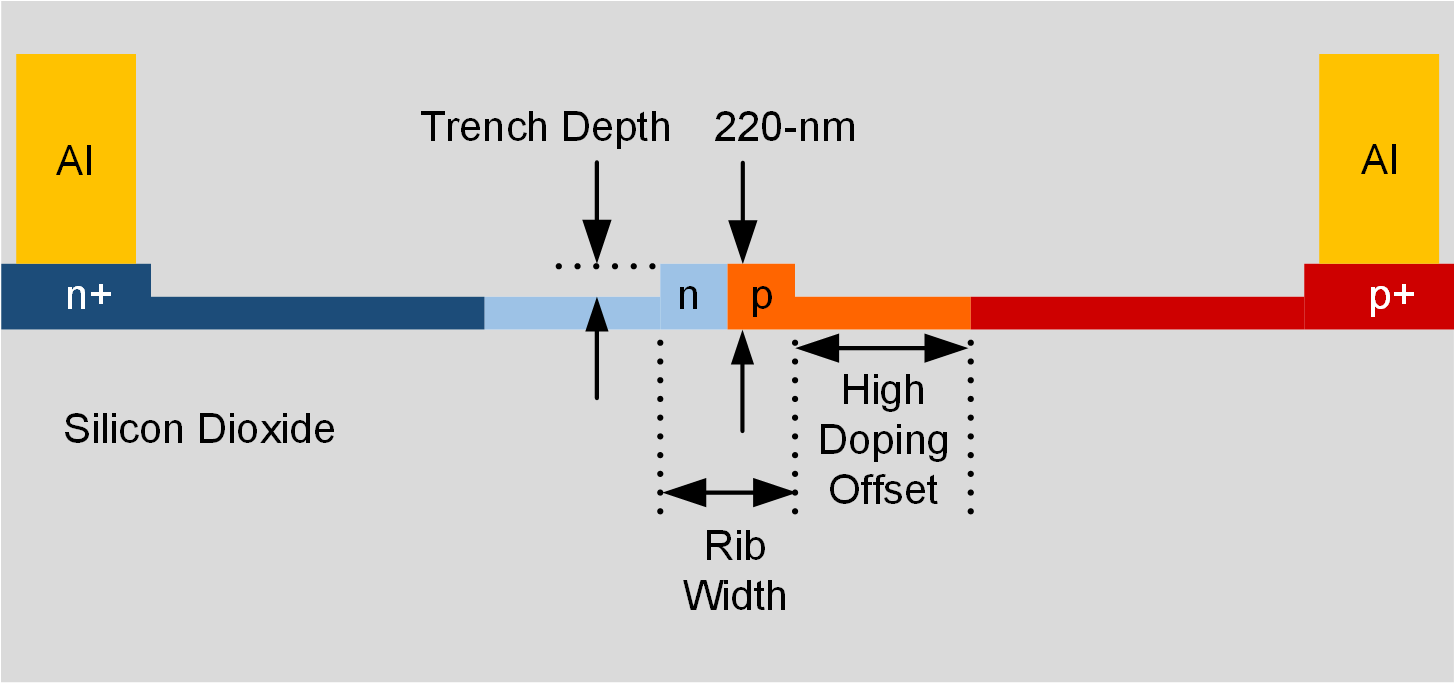

In [7]:
from IPython.core.display import Image
Image(url='https://i.imgur.com/m0uXmrY.png',embed=True,width=600)

<p style="font-size:18px">
Figure 2.
<p style="font-size:18px">
The geometry for a silicon photonic optical waveguide with a lateral pn junction. For this analysis in this notebook we will take the trench dept to be 110 nm.

In [8]:
nlow=1e17; plow=1e17; nhigh=1e19; phigh=1e19

# Set up figure p
p = figure(x_range=(-1,1), y_range=(-1,1), height=400, width=400)
p.xaxis.axis_label = "Horizontal Position (micron)"
p.yaxis.axis_label = "Vertical Position (micron)"

# Plot in figure p
source = ColumnDataSource({'image': [IA[:,:,0,2,0]]})   
stsource = ColumnDataSource(dict(x=[-1.0, -0.1, 0.1, 1.0], y=[0.11, 0.22, 0.11, 0.11]))
p.image(image='image', x=-1, y=-1, dw=2, dh=2, palette="Magma256", source=source)
p.line([-1.0, 1.0], [0.0, 0.0], line_color='white', line_width=1)
p.step('x', 'y', line_color='white', line_width=1, mode='after', source=stsource)
DWl_data = {'x':[depl_boundary(nlow,plow,0)[0]*1e6,depl_boundary(nlow,plow,0)[0]*1e6], 'y':[-0.1,0.3]}
DWl_source=ColumnDataSource(DWl_data)
DWr_data = {'x':[depl_boundary(nlow,plow,0)[1]*1e6,depl_boundary(nlow,plow,0)[1]*1e6], 'y':[-0.1,0.3]}
DWr_source=ColumnDataSource(DWr_data)
p.line('x', 'y', source=DWl_source, line_color="white", line_width=1, line_dash='4', legend='Depletion Region Boundaries')
p.line('x', 'y', source=DWr_source, line_color="white", line_width=1, line_dash='4')
p.legend.location = "bottom_center"
p.legend.label_text_color = "white"
p.legend.label_text_font_size = "12pt"
p.legend.background_fill_alpha = 0
p.legend.border_line_alpha = 0
p.yaxis.major_label_text_font_size = "12pt"

# Add Labels to p
nefflabel = Label(x=10, y=300, x_units='screen', y_units='screen', text_color='white',
                 text='neff = {}'.format("%.3f" % neff[0,0,0]), render_mode='css')
p.add_layout(nefflabel)
CFlabel = Label(x=10, y=280, x_units='screen', y_units='screen', text_color='white',
            text='Confinement Factor = {}'.format("%.3f" % CF[0,0,0]), render_mode='css')
p.add_layout(CFlabel)

# Set up figure pI
pI = figure(x_range=(-1,1), y_range=(-1,1), height=400, width=400)
pI.xaxis.axis_label = "Horizontal Position (micron)"
pI.yaxis.axis_label = "Vertical Position (micron)"

# Plot in figure pI
dI = doping(xms,yms,200e-9,110e-9,100e-9,3,1,8,11)
dsource = ColumnDataSource({'image': [dI]})
pI.image(image='image', x=-1, y=-1, dw=2, dh=2, palette="RdYlBu11", source=dsource)
pI.line([-1.0, 1.0], [0.0, 0.0], line_color='white', line_width=1)
pI.step('x', 'y', line_color='white', line_width=1, mode='after', source=stsource)

pI.line('x', 'y', source=DWl_source, line_color="white", line_width=1, line_dash='4', legend='Depletion Region Boundaries')
pI.line('x', 'y', source=DWr_source, line_color="white", line_width=1, line_dash='4')
pI.legend.location = "bottom_center"
pI.legend.label_text_color = "white"
pI.legend.label_text_font_size = "12pt"
pI.legend.background_fill_alpha = 0
pI.legend.border_line_alpha = 0

# Add labels to figure pI
doping_label = Label(x=16, y=130, x_units='screen', y_units='screen', text_color='white',
                 text='n+=1e19 ,' + ' n=1e17,' + ' p=1e17,' + ' p+=1e19', render_mode='css')
pI.add_layout(doping_label)
loss = 4.34*(numpy.sum(alpha(xml,yml,0,nlow,plow,nhigh,phigh,200e-9,110e-9,100e-9,1.55e-6)*IAlarge[:,:,0,2,0])/
        numpy.sum(IAlarge[:,:,0,2,0]))
losslabel = Label(x=10, y=300, x_units='screen', y_units='screen', text_color='white',
                 text='Loss = {}'.format("%.1f" % loss) + ' [dB/cm]', render_mode='css')
pI.add_layout(losslabel)
delta_delta_n = 0.0
ddn_label = Label(x=10, y=280, x_units='screen', y_units='screen', text_color='white',
        text='Delta n = {}'.format("%.2e" % delta_delta_n), render_mode='css')
pI.add_layout(ddn_label)

# *** Define sliders ***
slider_style = {'description_width': 'initial'}
slider=FloatSlider(min=200, max=750, step=50, value=200, description='Rib Width (nm)',
                            style=slider_style, continuous_update=True)
Trench_slider=FloatSlider(min=60, max=150.0, step=25, value = 110.0, description='Trench Depth (nm)', continuous_update=True,
                            style = {'description_width': '109px'}, layout={'width': '325px'})
spacer_slider=FloatSlider(min=0, max=600, step=50, value=100, description='High Doping Offset (nm)',
                            style = {'description_width': '140px'}, layout={'width': '356px'}, continuous_update=True)
V_slider=FloatSlider(min=-4, max=0, step=0.4, value=0, description='Voltage (V)',
                            style=slider_style, continuous_update=True)
wavelength_select = Dropdown(options=['1.3', '1.55'], value='1.55',
                            style=slider_style, description='Wavelength (micron)', disabled=False)

def replot(slider_value, spacer_value, V_value, wavelength_value):
    Trench_value=110
    j=round((slider.value-200)/50)
    k=round((Trench_value-60)/25)
    temp=wavelength_select.value
    wl=float(wavelength_select.value[:3])*1e-6
    global m
    if wl < 1.4e-6:
        m=round(0)
    else:
        m=round(1)
    source.data = {'image':[IA[:,:,j,k,m]]}
    stsource.data={'x': [-1.0, -slider.value/2000, slider.value/2000, 1.0], \
            'y': [0.22-Trench_slider.value*1e-3, 0.22, 0.22-Trench_value*1e-3,0.22-Trench_value*1e-3]}
    nefflabel.text = 'neff = {}'.format("%.3f" % neff[j,k,m])
    CFlabel.text = 'Confinement Factor = {}'.format("%.3f" % CF[j,k,m])
    dsource.data={'image':[doping(xms,yms,slider.value*1e-9,Trench_value*1e-9, spacer_slider.value*1e-9,3,1,8,11)]}
    DWl_source.data=({'x':[depl_boundary(nlow,plow,V_slider.value)[0]*1e6,depl_boundary(nlow,plow,V_slider.value)[0]*1e6],
                     'y':[-0.1,0.3]})
    DWr_source.data=({'x':[depl_boundary(nlow,plow,V_slider.value)[1]*1e6,depl_boundary(nlow,plow,V_slider.value)[1]*1e6],
                     'y':[-0.1,0.3]})
    loss0 = 4.34*(numpy.sum(alpha(xml,yml,0,nlow,plow,1e19,1e19,slider.value*1e-9,Trench_value*1e-9,
            spacer_slider.value*1e-9,wl)*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))
    loss = 4.34*(numpy.sum(alpha(xml,yml,V_slider.value,nlow,plow,1e19,1e19,slider.value*1e-9,Trench_value*1e-9,
            spacer_slider.value*1e-9,wl)*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))
    losslabel.text = 'Loss = {}'.format("%.2f" % loss) + 'dB/cm' 
    delta_delta_n = (numpy.sum((delta_n(xml,yml,V_slider.value,nlow,plow,1e19,1e19,
                        slider.value*1e-9,Trench_value*1e-9,spacer_slider.value*1e-9,wl)
                        -delta_n(xml,yml,0,nlow,plow,1e19,1e19,slider.value*1e-9,Trench_value*1e-9,
                        spacer_slider.value*1e-9,wl))*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))
    ddn_label.text = 'Delta n = {}'.format("%.2e" % delta_delta_n)
    push_notebook(handle=fig_handle)

fig_handle = show(row(p,pI), notebook_handle=True)
interact(replot, slider_value=slider, Trench_value=Trench_slider,
         spacer_value=spacer_slider, V_value=V_slider, wavelength_value=wavelength_select);

interactive(children=(FloatSlider(value=200.0, description='Rib Width (nm)', max=750.0, min=200.0, step=50.0, …

<p style="font-size:18px">
Figure 3. Left: The optical mode intensity in optical waveguides. Right: Doping profiles for the laterial pn junction. Use these interactive charts to see how the geometry of a waveguide with a lateral pn junction affects the loss and refractive-index change that can be acheived by applying a voltage to the junction.

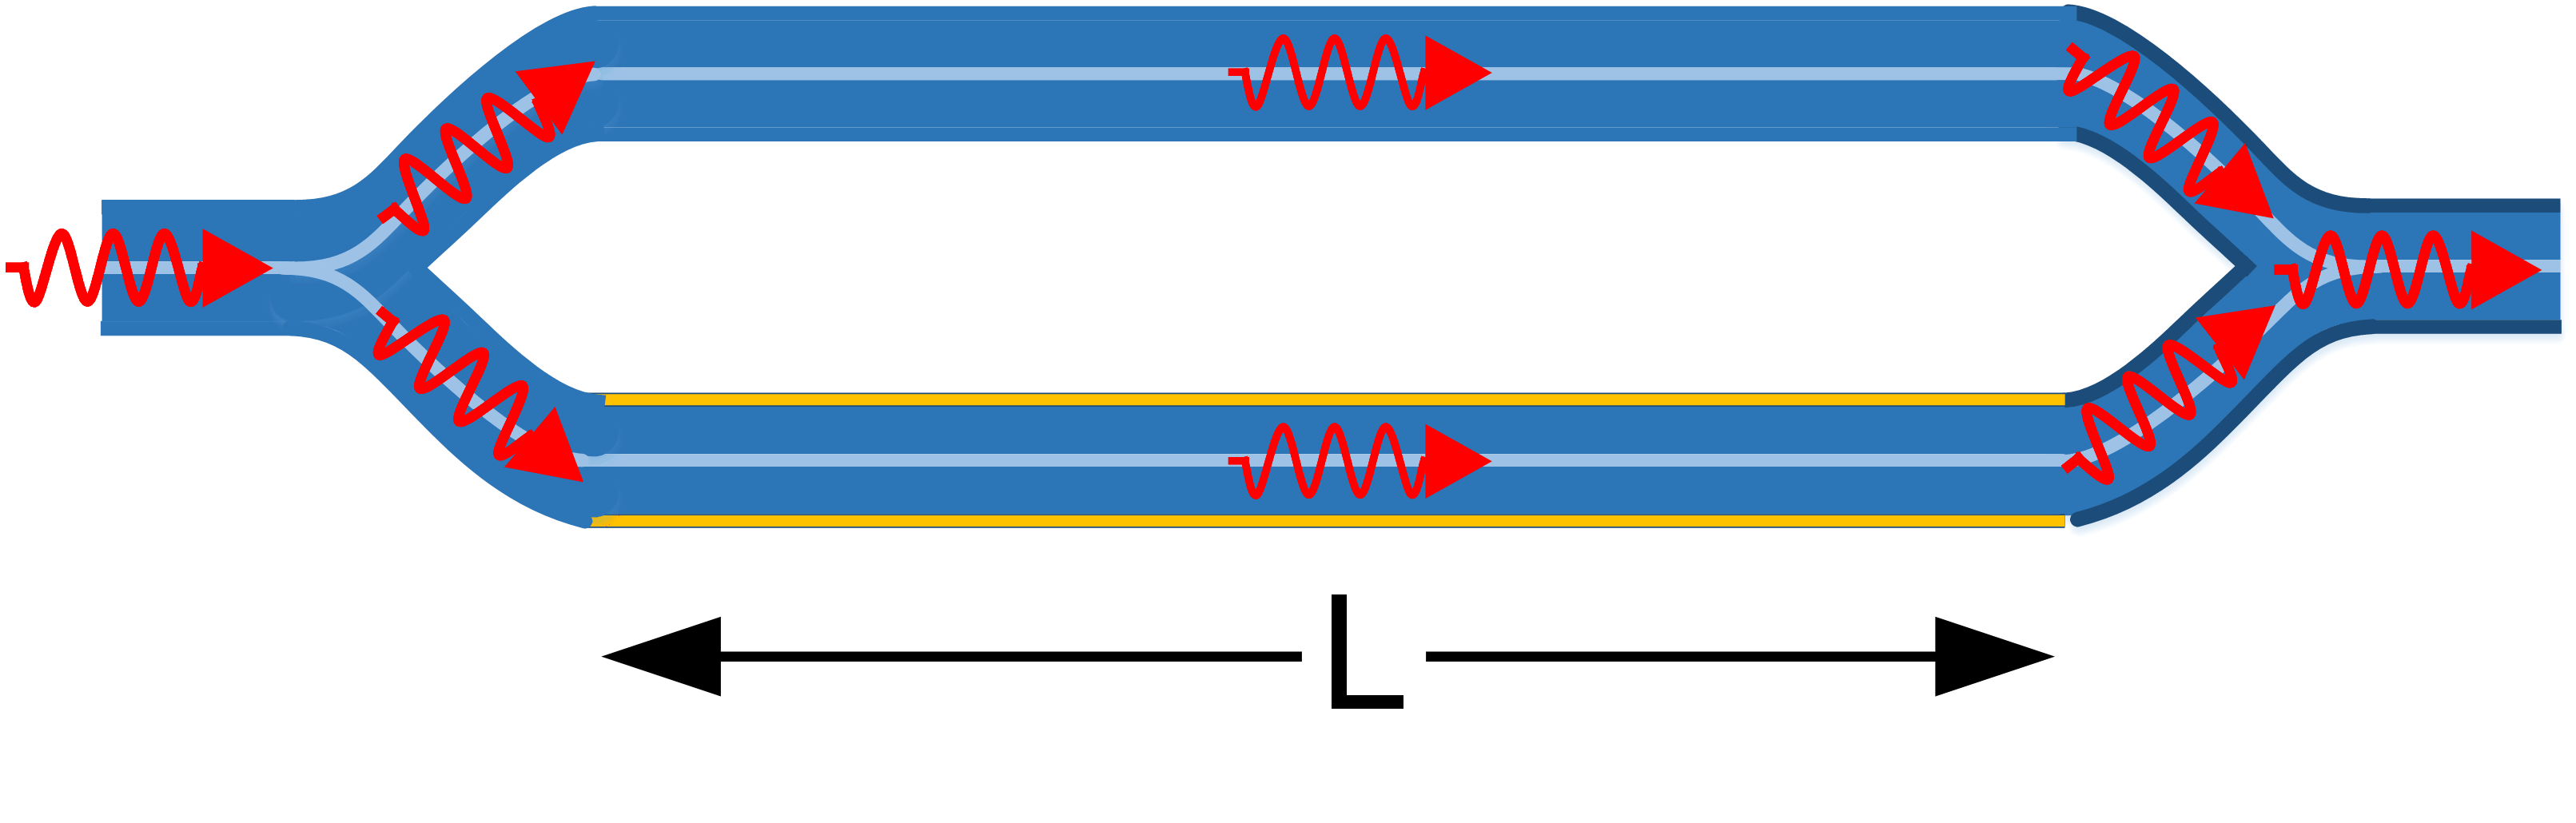

In [9]:
from IPython.core.display import Image
Image(url='https://i.imgur.com/UCZcFbi.png',embed=True,width=600)

<p style="font-size:18px">
Figure 4. An optical modualtor with a Mach-Zehnder configuration. Each arm of the modulator/interferometer has a geometric length of L. A voltage is applied to the pn junction in one of the two arms to achieve modulation. Directional couplers can also be used at the input and output of the modulator. The relative phase of the two arms can also be adjusted to achieve the highest possible extinction ratio.

In [11]:
L_slider = FloatSlider(min=2, max=8, step=0.25, value=2, description='Modulator Arm Length (mm)',
                   style = {'description_width': '180px'}, layout={'width': '410px'})
doping_select = Dropdown(options=["1e17", "5e17", "1e18"], value="1e17",
                    description='Doping ' + r'\(cm^{-3}\)', disabled=False,
                   style = {'description_width': '100px'}, layout={'width': '240px'})
phi_slider=FloatSlider(min=-90, max=90, step=1, value=0, description='Initial Relative Phase Between Arms (degrees)',
                       style = {'description_width': '270px'}, layout={'width': '530px'},
                        continuous_update=True)

j=round((450-200)/50)
k=round((110-60)/25)
temp=wavelength_select.value
wl=1.55*1e-6
if wl < 1.4e-6:
    m=round(0)
else:
    m=round(1)
L = 2; phi = 0
loss0 = 4.34*(numpy.sum(alpha(xml,yml,0,nlow,plow,1e19,1e19,450*1e-9,110*1e-9,
                600*1e-9,wl)*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))
loss = 4.34*(numpy.sum(alpha(xml,yml,-4,nlow,plow,1e19,1e19,450*1e-9,110*1e-9,
                600*1e-9,wl)*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))

V = numpy.linspace(0,-4,31)
loss_V = numpy.zeros((3,31))
delta_delta_n_V = numpy.zeros((3,31))
npconc=numpy.linspace(1e17,1e18,3)

for i in range(3):
    for n in range(31):
        delta_delta_n_V[i,n] = (numpy.sum((delta_n(xml,yml,V[n],npconc[i],npconc[i],1e19,1e19,
                    450*1e-9,110*1e-9,600*1e-9,wl)
                    -delta_n(xml,yml,0,npconc[i],npconc[i],1e19,1e19,450*1e-9,110*1e-9,
                    600*1e-9,wl))*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))
        loss_V[i,n] = (numpy.sum(alpha(xml,yml,V[n],npconc[i],npconc[i],1e19,1e19,450*1e-9,110*1e-9,
                    600*1e-9,wl)*IAlarge[:,:,j,k,m])/numpy.sum(IAlarge[:,:,j,k,m]))

T_V = ((0.5-0.5*numpy.cos(2*numpy.pi*delta_delta_n_V[0,:]*L*1e-3/wl)
                        *numpy.exp(-loss_V[0,:]/4.34*L/10))**2*numpy.exp(-3*L/10))

TV_data = {'x':V, 'y':T_V}
TV_source=ColumnDataSource(TV_data)
    
pT = figure(x_range=(0,-4), height=400, width=900)
pT.line('x', 'y', source=TV_source, line_color='darkblue')
pT.xaxis.axis_label = "Applied Voltage (V)"
pT.yaxis.axis_label = "Modulator Transmission"
pT.y_range = Range1d(0,0.35)

def rhon(p):
    return 0.24756-5.0567e-19*n+3.0111e-31*n**2
def rhop(n):
    return 0.11106-2.2417e-19*n+1.3611e-37*n**2

Rn_x_length = (rhon(nlow)/(220e-7-110*1e-7)*max((600*1e-7
        +450/2*1e-7+depl_boundary(nlow, plow, -4)[0]),0))
Rp_x_length = (rhop(plow)/(220e-7-110*1e-7)*max((600*1e-7
        +450/2*1e-7-depl_boundary(nlow, plow, -4)[1]),0))
R_x_length = Rn_x_length + Rp_x_length
R_label = Label(x=10, y=310, x_units='screen', y_units='screen', text_color='black',
        text='Resistance = {}'.format("%.1e" % R_x_length)+ ' [ohm-cm]', render_mode='css')
pT.add_layout(R_label)

kB=1.38e-23; q=1.602e-19; T=300; ni=1.5e16; ep0=8.854e-12; eps=11.9
Vbi=(kB*T/q)*numpy.log(plow*nlow/ni**2)
Cap = 220e-9*numpy.sqrt((q*ep0*eps)/(2*(1/nlow+1/plow)*1e-6*(Vbi+4)))*1e-2
f = 1/(2*numpy.pi*R_x_length*Cap)*1e-9
C_label = Label(x=10, y=290, x_units='screen', y_units='screen', text_color='black',
        text='Capacitance = {}'.format("%.1e" % Cap)+ ' [F/cm]', render_mode='css')
pT.add_layout(C_label)
f_label = Label(x=10, y=270, x_units='screen', y_units='screen', text_color='black',
        text='Bandwidth @ -4V = {}'.format("%.1f" % f)+ ' [GHz]', render_mode='css')
pT.add_layout(f_label)


def replot2(Lnew,npconc):
    if npconc == '1e18':
        i = 2
        npnew=1e18
    elif npconc == '5e17':
        i = 1
        npnew=5e17
    else:
        i = 0
        npnew=1e17
    phi_new = phi_slider.value*numpy.pi/180
    TV_source.data = {'x':V,
                        'y':((0.5*numpy.cos(phi_new)-0.5*numpy.cos(2*numpy.pi*delta_delta_n_V[i,:]*Lnew*1e-3/wl)
                        *numpy.exp(-loss_V[i,:]/4.34*Lnew/10))**2*numpy.exp(-3*Lnew/10))}
    Rn_x_length = (rhon(npnew)/(220e-7-110*1e-7)*max((600*1e-7
            +450/2*1e-7+depl_boundary(npnew, npnew, -4)[0]),0))
    Rp_x_length = (rhop(npnew)/(220e-7-110*1e-7)*max((600*1e-7
        +450/2*1e-7-depl_boundary(npnew, npnew, -4)[1]),0))
    R_x_length = Rn_x_length + Rp_x_length
    R_label.text = 'Resistance = {}'.format("%.1e" %R_x_length)+ ' [ohm-cm]'
    Cap = 220e-9*numpy.sqrt((q*ep0*eps)/(2*(1/npnew+1/npnew)*1e-6*(Vbi+4)))*1e-2
    C_label.text = 'Capacitance = {}'.format("%.1e" % Cap)+ ' [F/cm]'
    f = 1/(2*numpy.pi*R_x_length*Cap)*1e-9
    f_label.text='Bandwidth @ -4V = {}'.format("%.1f" % f)+ ' [GHz]'  

    push_notebook(handle=fig_handle2)

fig_handle2 = show(pT, notebook_handle=True)
interact(replot2, Lnew=L_slider, npconc=doping_select);

interactive(children=(FloatSlider(value=2.0, description='Modulator Arm Length (mm)', layout=Layout(width='410…

<p style="font-size:18px">
Figure 5. Modulator transmission versus applied voltage. Calculations are made with a rib widht of 450 nm, a high-doping offeset of 600 nm, and a wavelength of 1.55 micron.Select different doping levels and adjust the arms for maximum modulator transmission. Examine how modulation depth and electrical bandwidth vary with doping.